In [1]:
!pip install flash-attn==2.6.3


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Stable RMSE: 1.563
Drift RMSE: 1.447
Robustness Ratio (Drift/Stable): 0.926
Directional Accuracy: 100.00%


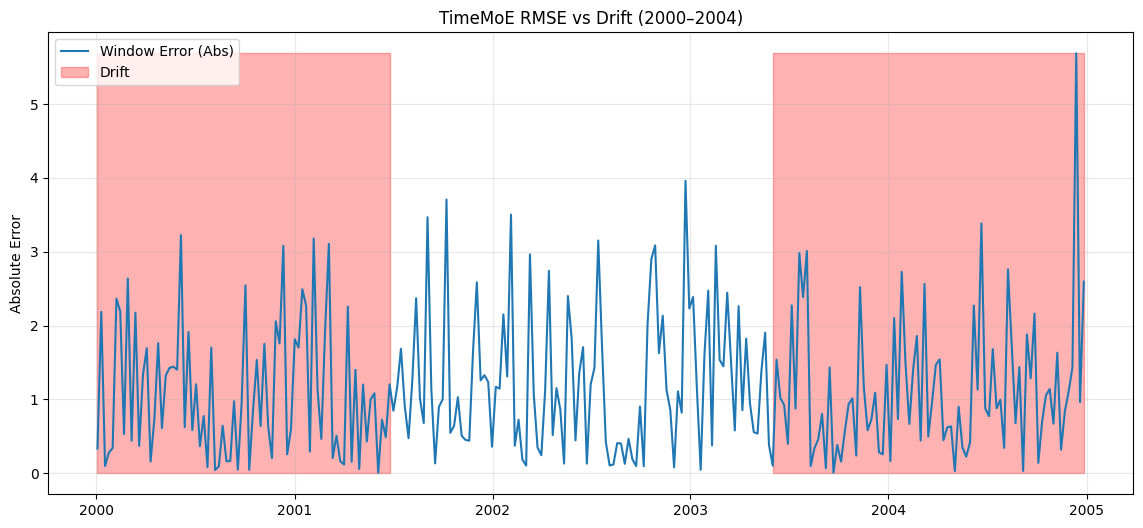

In [3]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForCausalLM
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

df = pd.read_csv("../Data/SynData.csv", parse_dates=['date'])
df = df.sort_values("date")

train_df = df[df['date'] < '2000-01-01']
infer_df = df[(df['date'] >= '2000-01-01') & (df['date'] <= '2004-12-31')]

context_length = 64
prediction_length = 1
target_series = df['var1'].values
dates = df['date']
drift_flags = df['drift_period'].values

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForCausalLM.from_pretrained(
    'Maple728/TimeMoE-50M',
    device_map=device,
    trust_remote_code=True,
)
model.to(device)
model.eval()

results = []

for idx in range(len(df)):
    if dates.iloc[idx] < pd.Timestamp('2000-01-01') or dates.iloc[idx] > pd.Timestamp('2004-12-31'):
        continue
    if idx - context_length < 0 or idx + prediction_length > len(df):
        continue

    input_window = target_series[idx - context_length:idx]
    true_value = target_series[idx:idx + prediction_length]
    drift_flag = drift_flags[idx]

    try:
        input_seq = torch.tensor(input_window, dtype=torch.float32, device=device).unsqueeze(0)
        mean = input_seq.mean(dim=-1, keepdim=True)
        std = input_seq.std(dim=-1, keepdim=True)
        normed_seq = (input_seq - mean) / std

        with torch.no_grad():
            output = model.generate(normed_seq, max_new_tokens=prediction_length)

        normed_pred = output[:, -prediction_length:]
        prediction = (normed_pred * std + mean).squeeze(0).cpu().numpy()[0]

        results.append({
            "date": dates.iloc[idx + prediction_length - 1],
            "actual": true_value[0],
            "predicted": prediction,
            "drift_flag": drift_flag
        })

    except Exception as e:
        print(f"⚠️ Skipped index {idx}: {e}")


res_df = pd.DataFrame(results)

drift_rmse = np.sqrt(mean_squared_error(res_df[res_df['drift_flag'] == 1]['actual'],
                                        res_df[res_df['drift_flag'] == 1]['predicted']))
stable_rmse = np.sqrt(mean_squared_error(res_df[res_df['drift_flag'] == 0]['actual'],
                                         res_df[res_df['drift_flag'] == 0]['predicted']))
robustness_ratio = drift_rmse / stable_rmse

print(f"Stable RMSE: {stable_rmse:.3f}")
print(f"Drift RMSE: {drift_rmse:.3f}")
print(f"Robustness Ratio (Drift/Stable): {robustness_ratio:.3f}")

directional_acc = np.mean(
    np.sign(res_df['actual'].values) == np.sign(res_df['predicted'].values)
)
print(f"Directional Accuracy: {directional_acc:.2%}")

plt.figure(figsize=(14, 6))
plt.plot(res_df['date'], abs(res_df['actual'] - res_df['predicted']), label='Window Error (Abs)')
plt.fill_between(res_df['date'], 0, abs(res_df['actual'] - res_df['predicted']).max(),
                 where=res_df['drift_flag'] == 1, alpha=0.3, color='red', label='Drift')
plt.title("TimeMoE RMSE vs Drift (2000–2004)")
plt.ylabel("Absolute Error")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



===== Test 1: Stable → Drift =====


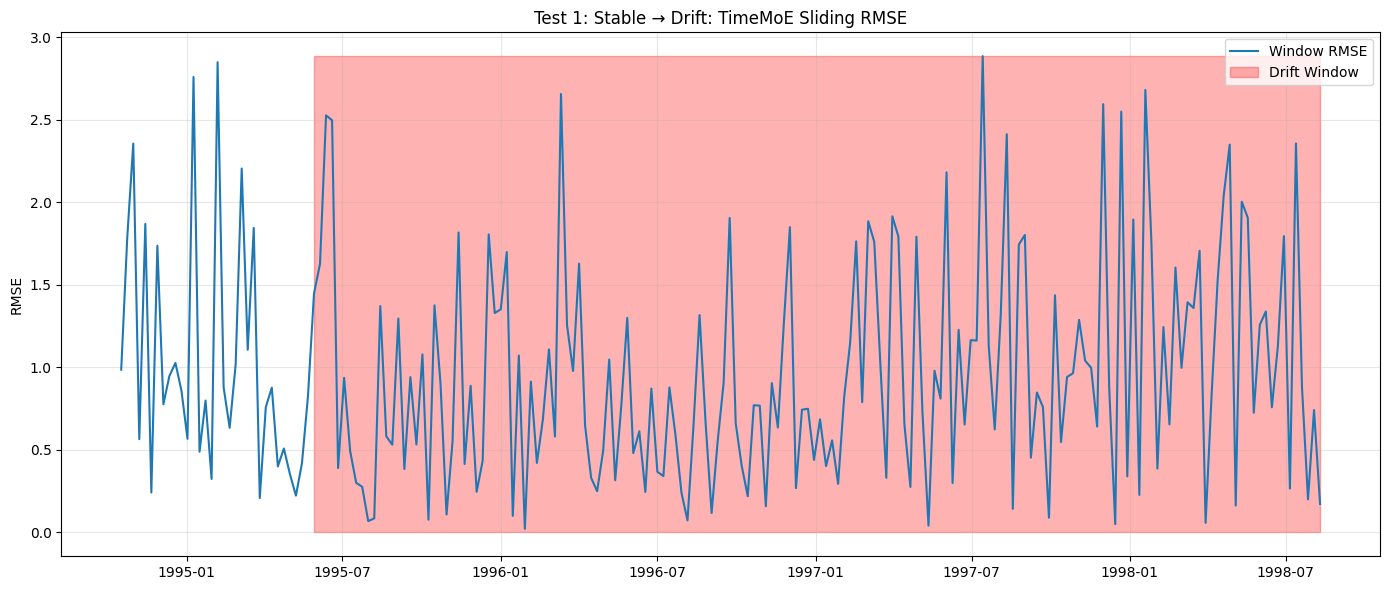

Stable RMSE: 1.038
Drift RMSE: 0.963
Robustness Ratio (Drift/Stable): 0.927

===== Test 2: Balanced Mix =====


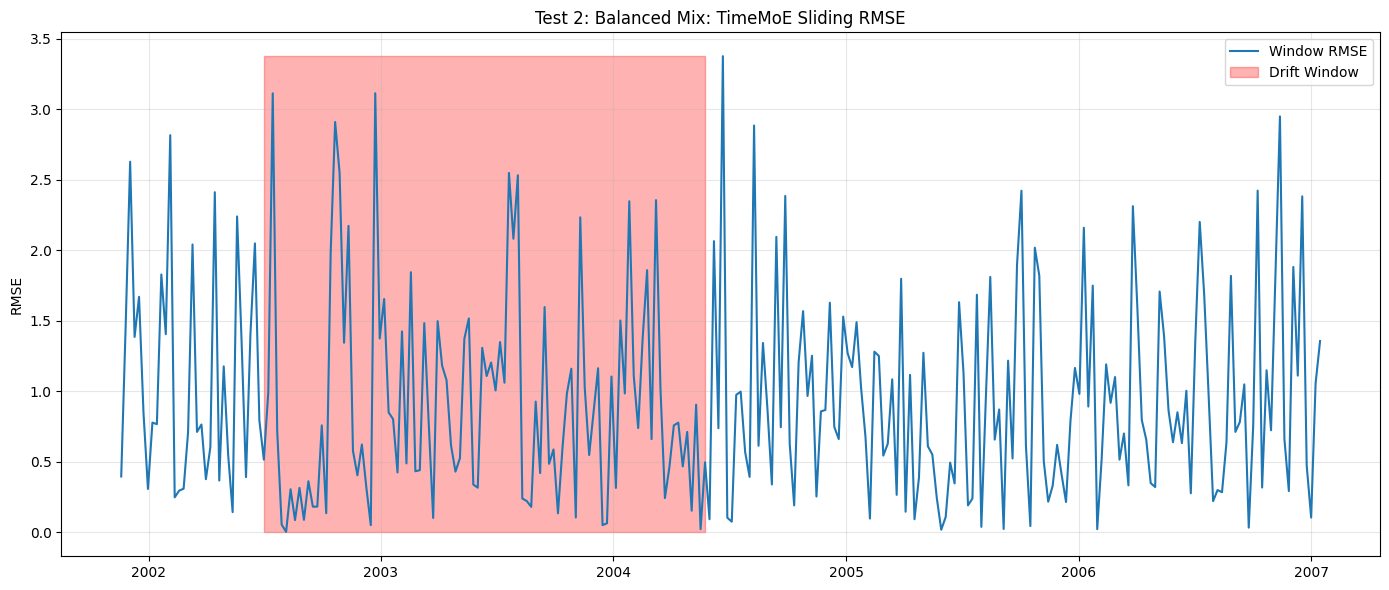

Stable RMSE: 0.979
Drift RMSE: 0.931
Robustness Ratio (Drift/Stable): 0.951

===== Test 3: Long Train, Short Inference =====


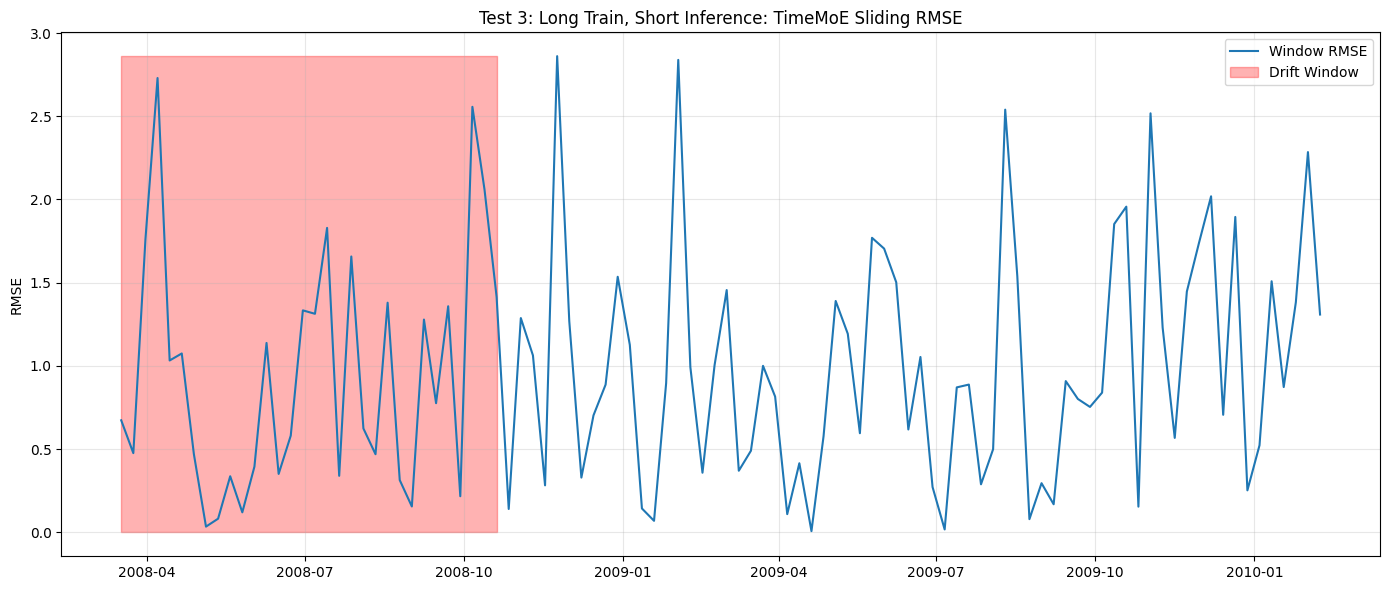

Stable RMSE: 0.998
Drift RMSE: 0.948
Robustness Ratio (Drift/Stable): 0.950

===== Test 4: Stable Only → Long Drift =====


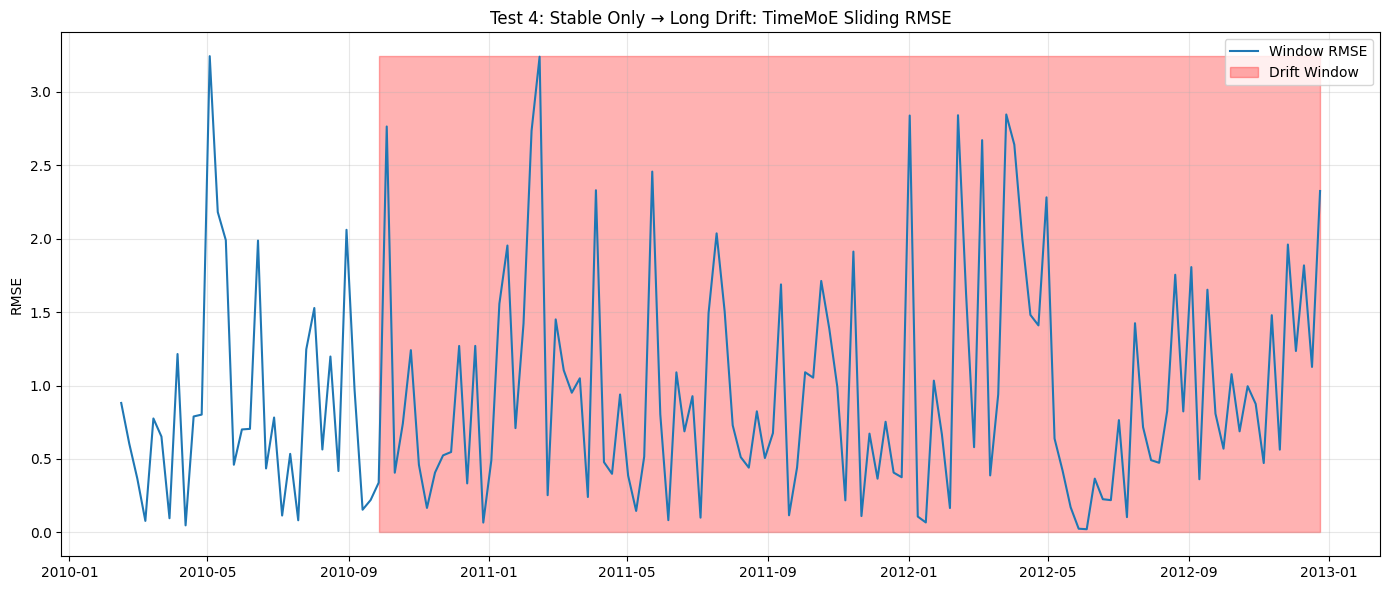

Stable RMSE: 0.872
Drift RMSE: 0.991
Robustness Ratio (Drift/Stable): 1.137

===== Test 5: Rolling Regimes =====


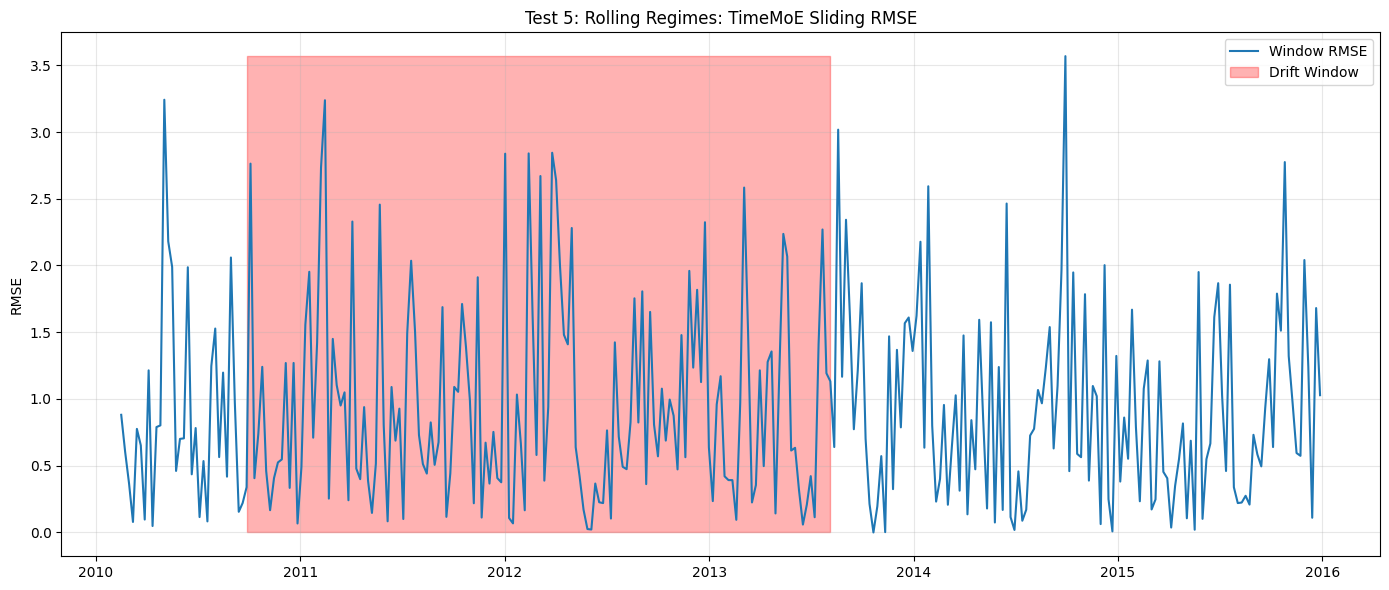

Stable RMSE: 0.911
Drift RMSE: 0.968
Robustness Ratio (Drift/Stable): 1.063


In [9]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForCausalLM
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


df = pd.read_csv("../Data/simulateddata.csv", parse_dates=["date"], index_col="date")
df = df.sort_index()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForCausalLM.from_pretrained(
    'Maple728/TimeMoE-50M',
    device_map=device,
    trust_remote_code=True
)
model.to(device)
model.eval()

context_length = 64
prediction_length = 1

test_cases = [
    ("Test 1: Stable → Drift", 
     "1990-01-01", "1994-10-10",   
     "1994-10-17", "1998-08-10"), 

    ("Test 2: Balanced Mix", 
     "1994-10-17", "2001-11-12",   
     "2001-11-19", "2007-01-15"),  

    ("Test 3: Long Train, Short Inference", 
     "1990-01-01", "2008-03-10",  
     "2008-03-17", "2010-02-08"), 

    ("Test 4: Stable Only → Long Drift", 
     "1990-01-01", "2010-02-08",  
     "2010-02-15", "2012-12-24"), 

    ("Test 5: Rolling Regimes", 
     "1990-01-01", "2010-02-08",   
     "2010-02-15", "2015-12-28")   
]


target_series = df['var1'].values
dates = df.index

for test_name, train_start, train_end, infer_start, infer_end in test_cases:
    print(f"\n===== {test_name} =====")

    results = []

    for idx in range(len(df)):
        pred_time_idx = idx + prediction_length - 1
        if pred_time_idx >= len(df):
            continue

        pred_time = dates[pred_time_idx]

        if not (pd.Timestamp(infer_start) <= pred_time <= pd.Timestamp(infer_end)):
            continue

        if idx - context_length < 0:
            continue

        input_window = target_series[idx - context_length:idx]
        true_value = target_series[idx:idx + prediction_length][0]
        drift_flag = int(df.iloc[idx - context_length:idx + prediction_length]['drift_period'].mean() > 0.5)


        try:
            input_seq = torch.tensor(input_window, dtype=torch.float32, device=device).unsqueeze(0)
            mean = input_seq.mean(dim=-1, keepdim=True)
            std = input_seq.std(dim=-1, keepdim=True)
            normed_seq = (input_seq - mean) / std

            with torch.no_grad():
                output = model.generate(normed_seq, max_new_tokens=prediction_length)

            normed_pred = output[:, -prediction_length:]
            prediction = (normed_pred * std + mean).squeeze(0).cpu().numpy()[0]

            results.append({
                "date": pred_time,
                "actual": true_value,
                "predicted": prediction,
                "is_drift": drift_flag
            })

        except Exception as e:
            print(f"⚠️ Skipped index {idx}: {e}")

    results_df = pd.DataFrame(results).set_index('date')
    results_df['rmse'] = np.sqrt((results_df['actual'] - results_df['predicted']) ** 2)

    plt.figure(figsize=(14, 6))
    plt.plot(results_df.index, results_df['rmse'], label='Window RMSE')
    plt.fill_between(results_df.index, 0, results_df['rmse'].max(),
                     where=results_df['is_drift'] == 1, color='red', alpha=0.3, label='Drift Window')
    plt.title(f'{test_name}: TimeMoE Sliding RMSE')
    plt.ylabel('RMSE')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    drift_rmse = results_df[results_df['is_drift'] == 1]['rmse'].mean()
    stable_rmse = results_df[results_df['is_drift'] == 0]['rmse'].mean()
    robustness_ratio = drift_rmse / stable_rmse if stable_rmse > 0 else float('nan')

    print(f"Stable RMSE: {stable_rmse:.3f}")
    print(f"Drift RMSE: {drift_rmse:.3f}")
    print(f"Robustness Ratio (Drift/Stable): {robustness_ratio:.3f}")


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



===== Test 1: Stable → Drift =====


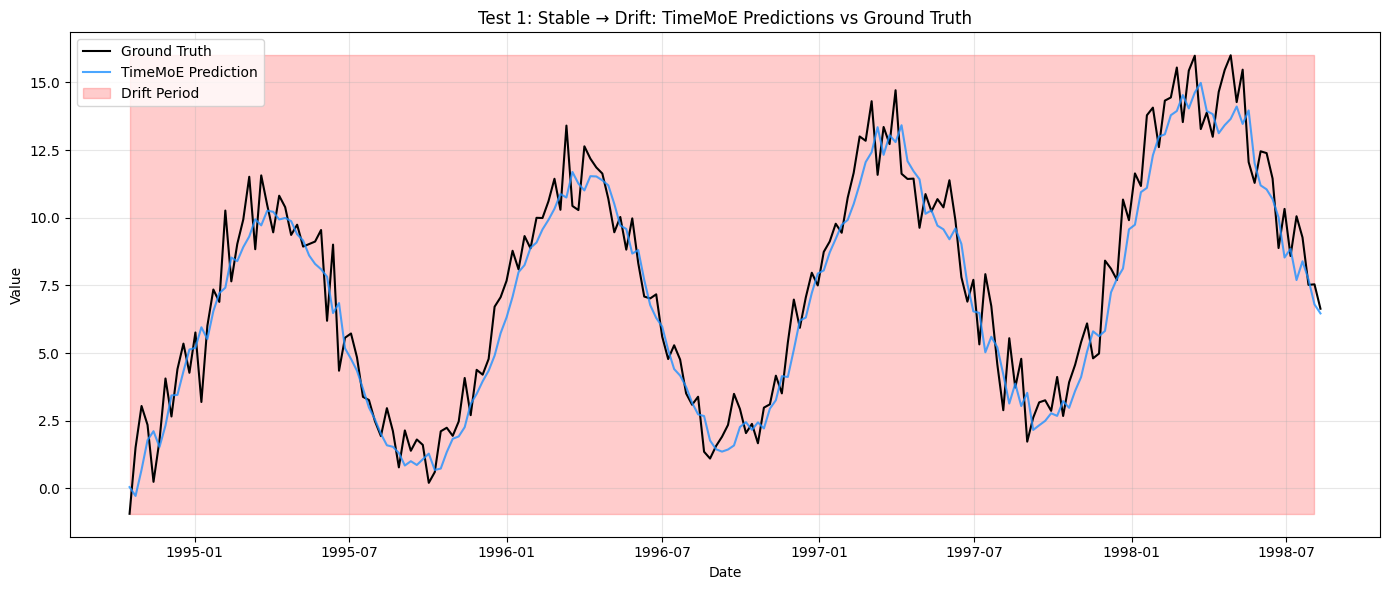


===== Test 2: Balanced Mix =====


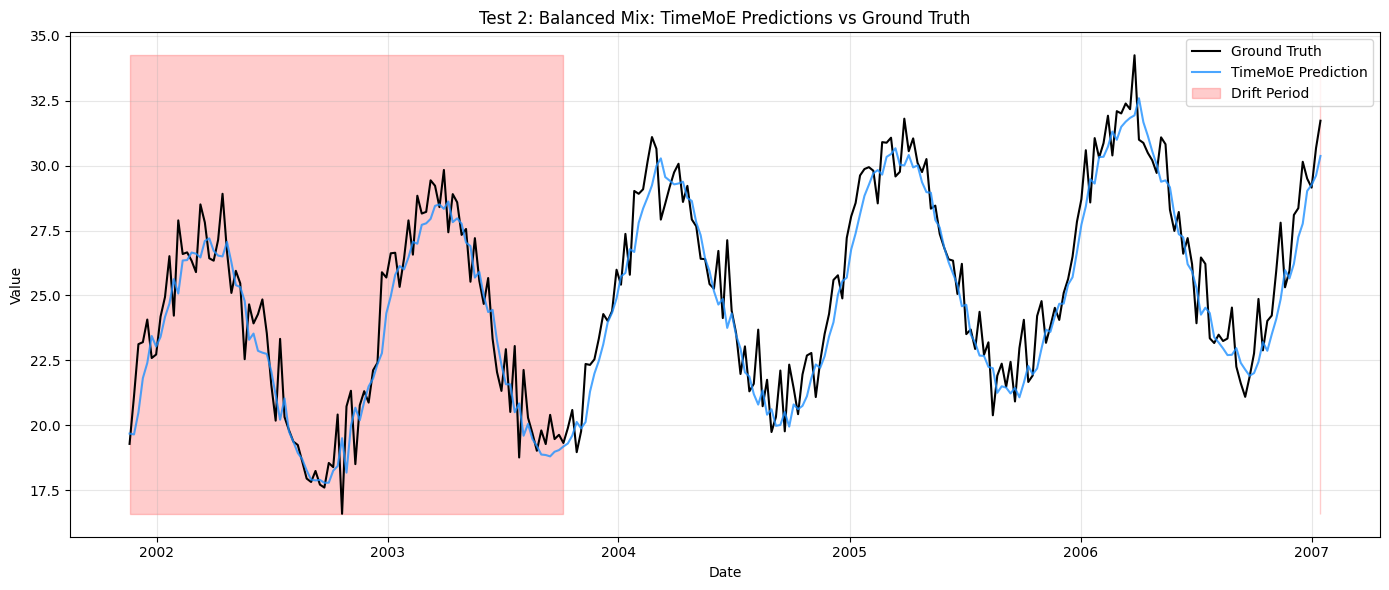


===== Test 3: Long Train, Short Inference =====


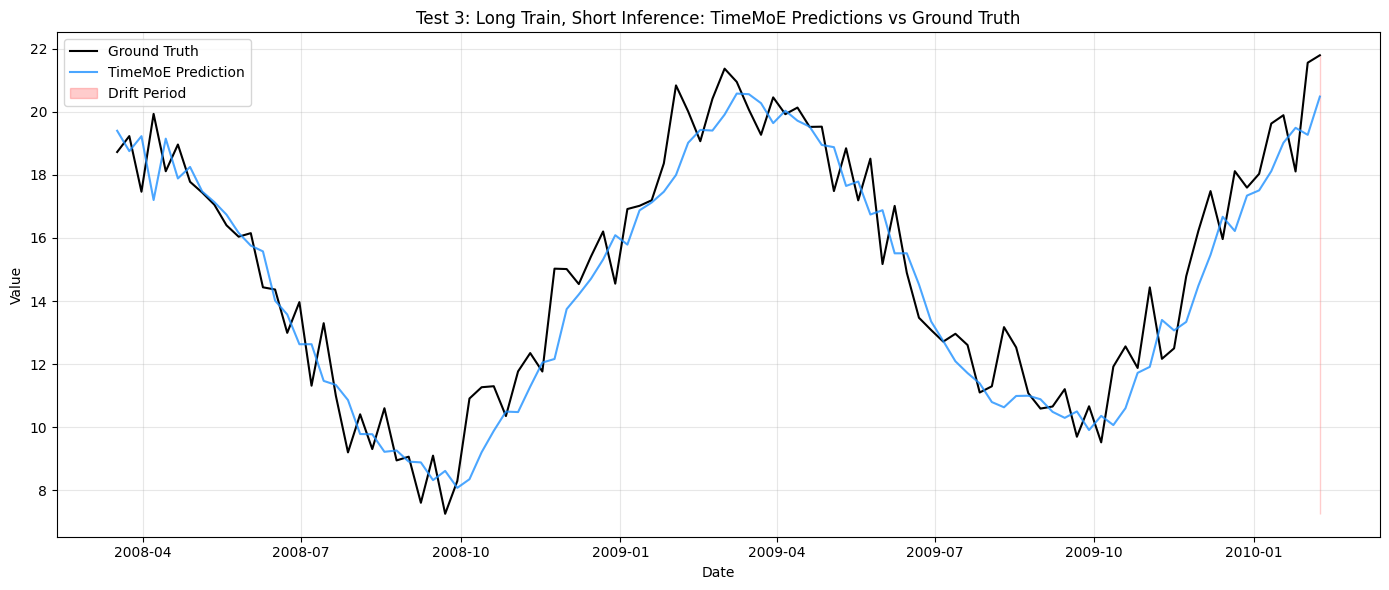


===== Test 4: Stable Only → Long Drift =====


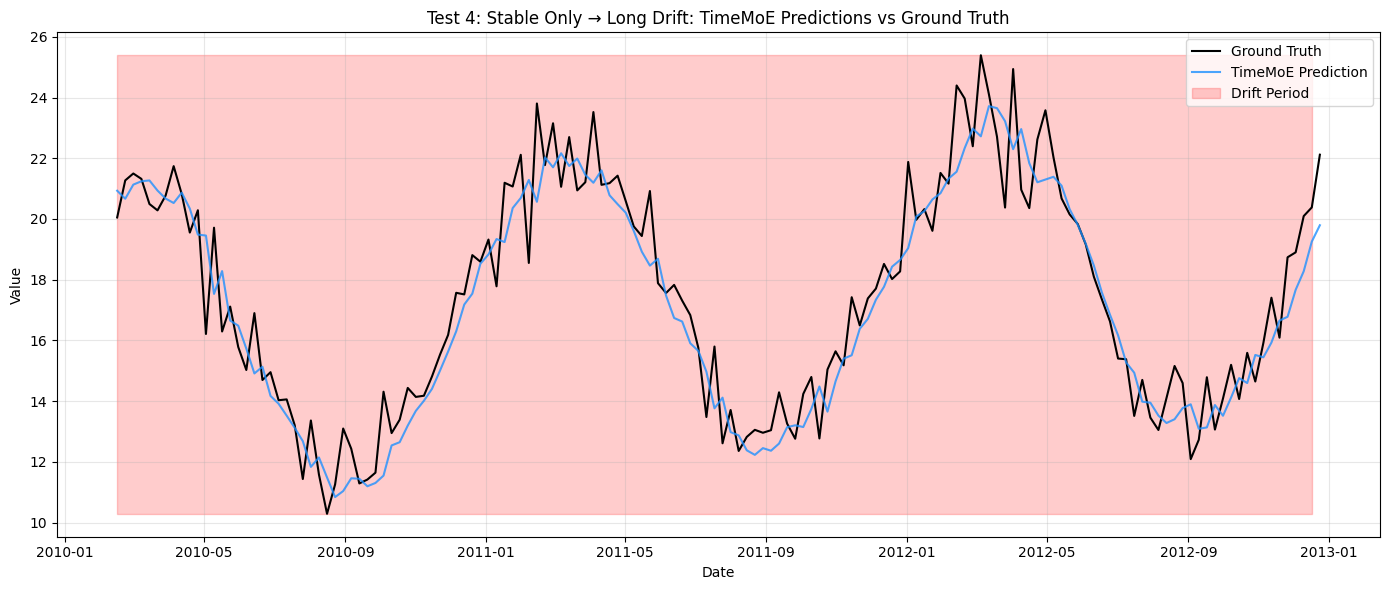


===== Test 5: Rolling Regimes =====


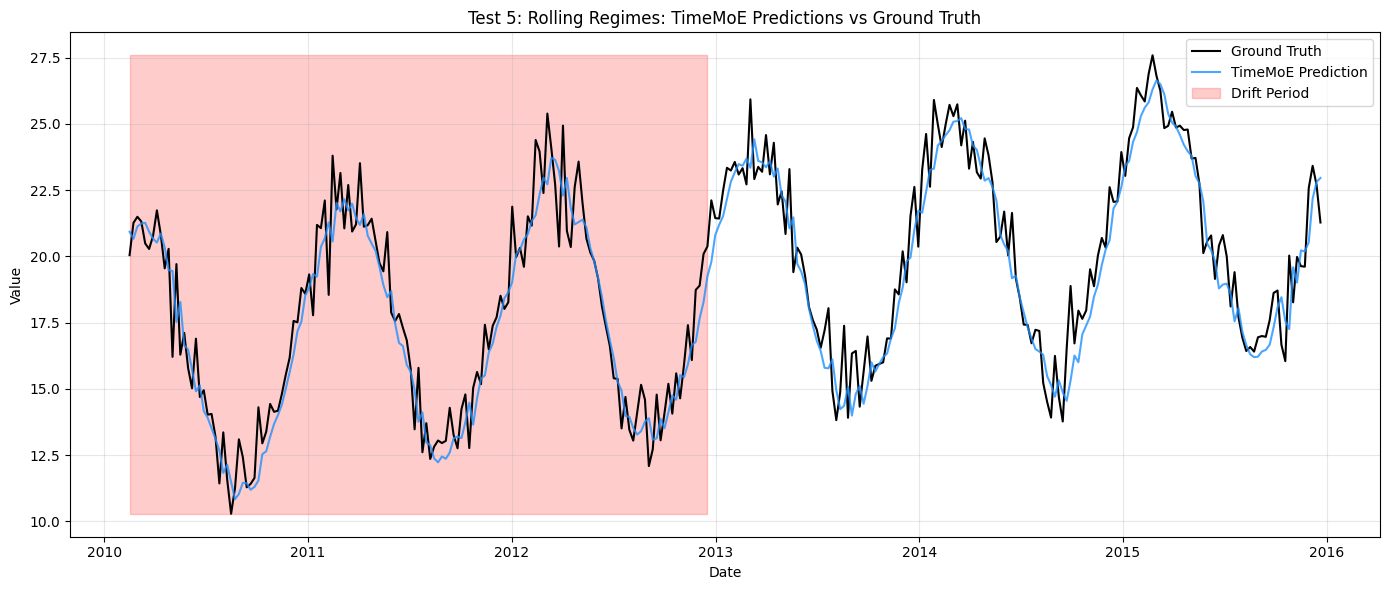

In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForCausalLM
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


df = pd.read_csv("../Data/simulateddata.csv", parse_dates=["date"], index_col="date")
df = df.sort_index()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForCausalLM.from_pretrained(
    'Maple728/TimeMoE-50M',
    device_map=device,
    trust_remote_code=True
)
model.to(device)
model.eval()

context_length = 64
prediction_length = 1

test_cases = [
    ("Test 1: Stable → Drift", "1990-01-01", "1994-10-10", "1994-10-17", "1998-08-10"),
    ("Test 2: Balanced Mix", "1994-10-17", "2001-11-12", "2001-11-19", "2007-01-15"),
    ("Test 3: Long Train, Short Inference", "1990-01-01", "2008-03-10", "2008-03-17", "2010-02-08"),
    ("Test 4: Stable Only → Long Drift", "1990-01-01", "2010-02-08", "2010-02-15", "2012-12-24"),
    ("Test 5: Rolling Regimes", "1990-01-01", "2010-02-08", "2010-02-15", "2015-12-28")
]

target_series = df['var1'].values
dates = df.index

for test_name, train_start, train_end, infer_start, infer_end in test_cases:
    print(f"\n===== {test_name} =====")

    results = []

    for idx in range(len(df)):
        pred_time_idx = idx + prediction_length - 1
        if pred_time_idx >= len(df):
            continue

        pred_time = dates[pred_time_idx]

        if not (pd.Timestamp(infer_start) <= pred_time <= pd.Timestamp(infer_end)):
            continue

        if idx - context_length < 0:
            continue

        input_window = target_series[idx - context_length:idx]
        true_value = target_series[idx:idx + prediction_length][0]
        if idx + prediction_length >= len(df):
            continue
        drift_flag = int(df.iloc[idx + prediction_length]['drift_period'])

        try:
            input_seq = torch.tensor(input_window, dtype=torch.float32, device=device).unsqueeze(0)
            mean = input_seq.mean(dim=-1, keepdim=True)
            std = input_seq.std(dim=-1, keepdim=True)
            normed_seq = (input_seq - mean) / std

            with torch.no_grad():
                output = model.generate(normed_seq, max_new_tokens=prediction_length)

            normed_pred = output[:, -prediction_length:]
            prediction = (normed_pred * std + mean).squeeze(0).cpu().numpy()[0]

            results.append({
                "date": pred_time,
                "actual": true_value,
                "predicted": prediction,
                "is_drift": drift_flag
            })

        except Exception as e:
            print(f" Skipped index {idx}: {e}")

    results_df = pd.DataFrame(results).set_index('date')
    results_df = results_df.join(df[['drift_period']], how='left').rename(columns={'drift_period': 'drift_flag'})


    plt.figure(figsize=(14, 6))
    plt.plot(results_df.index, results_df['actual'], label='Ground Truth', color='black', linewidth=1.5)
    plt.plot(results_df.index, results_df['predicted'], label='TimeMoE Prediction', color='dodgerblue', alpha=0.8)
    plt.fill_between(results_df.index, 
                     results_df['actual'].min(), results_df['actual'].max(),
                     where=results_df['is_drift'] == 1,
                     color='red', alpha=0.2, label='Drift Period')
    plt.title(f'{test_name}: TimeMoE Predictions vs Ground Truth')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
